# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [ ]:
import os,sys

In [2]:

import hmmlearn
import numpy as np
import pandas as pd
from asl_data import AslDb

asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [3]:
# needed later convert all features to float values
for col in asl.df:
    if col != 'speaker':
        asl.df[col] = asl.df[col].astype(np.float32)

In [4]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [5]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   
      1       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   
      2       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   
      3       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   
      4       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   

             grnd-ry  
video frame           
98    0        113.0  
      1        113.0  
      2        113.0  
      3        113.0  
      4        113.0

##### Try it!

In [6]:
from asl_utils import test_features_tryit
# DONE add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations

asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']


# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   
      1       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   
      2       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   
      3       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   
      4       149.0   181.0    170.0    175.0   161.0    62.0  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0        113.0      9.0    119.0    -12.0  
      1        113.0      9.0    119.0    -12.0  
      2        113.0      9.0    119.0    -12.0  
      3        113.0      9.0    119.0    -12.0  
      4        113.0      9.0    119.0    -12.0

In [7]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9.0, 113.0, -12.0, 119.0]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [8]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


#### Normalized features coordinates

In [9]:
# DONE add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

lookup=asl.df.groupby('speaker').transform(lambda df: (df - df.mean()) / df.std())

asl.df = asl.df.assign(**{'norm-rx': lookup['right-x'],
                       'norm-lx': lookup['left-x'],
                       'norm-ry': lookup['right-y'],
                       'norm-ly': lookup['left-y']})

#### Polar coordinates

In [10]:
# DONE add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

asl.df['polar-lr'] = np.sqrt((asl.df['left-x'] - asl.df['nose-x'])**2 + (asl.df['left-y'] - asl.df['nose-y'])**2)
asl.df['polar-rr'] = np.sqrt((asl.df['right-x'] - asl.df['nose-x'])**2 + (asl.df['right-y'] - asl.df['nose-y'])**2)

asl.df['polar-ltheta'] = np.arctan2((asl.df['left-x'] - asl.df['nose-x']), (asl.df['left-y'] - asl.df['nose-y']))
asl.df['polar-rtheta'] = np.arctan2((asl.df['right-x'] - asl.df['nose-x']), (asl.df['right-y'] - asl.df['nose-y']))




#### Differences of coordinates

In [11]:
# DONE add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)


In [45]:
# DONE add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# DONE define a list named 'features_custom' for building the training set

features_custom= ['norm-polar-lr',
                  'norm-polar-rr', 
                  'polar-ltheta', 
                  'polar-rtheta', 
                  'norm-delta-polar-lr', 
                  'norm-delta-polar-rr', 
#                   'norm-delta-polar-ltheta', 
#                   'norm-delta-polar-rtheta'
                 ]

asl.df['delta-polar-lr'] = asl.df['polar-lr'].diff().fillna(0)
asl.df['delta-polar-rr'] = asl.df['polar-rr'].diff().fillna(0)
asl.df['delta-polar-ltheta'] = asl.df['polar-ltheta'].diff().fillna(0)
asl.df['delta-polar-rtheta'] = asl.df['polar-rtheta'].diff().fillna(0)

lookup=asl.df.groupby('speaker').transform(lambda df: (df - df.mean()) / df.std())

asl.df = asl.df.assign(**{'norm-polar-lr': lookup['polar-lr'],
                       'norm-polar-rr': lookup['polar-rr'],
                       'norm-polar-ltheta': lookup['polar-ltheta'],
                       'norm-polar-rtheta': lookup['polar-rtheta'],
                       'norm-delta-polar-lr': lookup['delta-polar-lr'],
                       'norm-delta-polar-rr': lookup['delta-polar-rr'],
                       'norm-delta-polar-ltheta': lookup['delta-polar-ltheta'],
                       'norm-delta-polar-rtheta': lookup['delta-polar-rtheta'],
                         }    
                      )



In [46]:
%matplotlib inline

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

As custom features I decided to used normalized polar coordinates and their temporal differences. First, polar coordinates maybe easier to interpret for the classifier due to the geometry of the problem (simmetry of some gestures). Second, the angle in polar coordinates is more robust to the differences in lengths of the arms of the speaker. Third, to make the features even more robust to this variability in appearence, I also decided to rescale temporal differences using the `z-score` transform. 

As we can see from the graph and the table below the difference in the distribution of these features among the speakers are suppressed by these transformations, while the features remain mostly uncorrelated hence have the possibilty to convey different sources of information to the classifier.

In [47]:
# Distribution features among speakers
asl.df.groupby('speaker').describe()[['polar-rr','norm-polar-rr']].loc[pd.IndexSlice[:,['mean','std']],:].unstack()

polar-rr            norm-polar-rr     
              mean        std          mean  std
speaker                                         
man-1    95.464417  49.130795 -1.074241e-07  1.0
woman-1  65.125534  30.654062 -1.828395e-07  1.0
woman-2  67.297447  35.581421  3.065382e-08  1.0

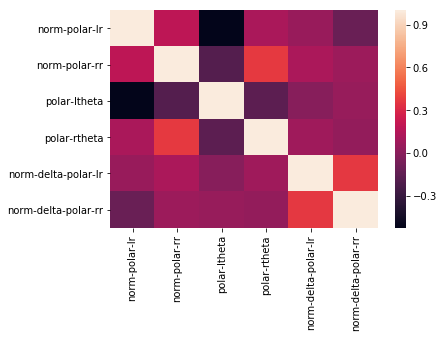

In [48]:
# feature correlation
import seaborn as sns
corr = asl.df[features_custom].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [16]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.039s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [17]:
import warnings
import hmmlearn
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    model.fnames =  features
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433164


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [18]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444032]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434595  16.83041493  30.51552304  11.03678246]



In [19]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057774]
variance =  [ 16.16920956  46.50917374   3.81388185  15.79446425]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073875   64.13103127   13.68077479  129.59123952]

logL = -601.329147002859


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [20]:
%matplotlib inline

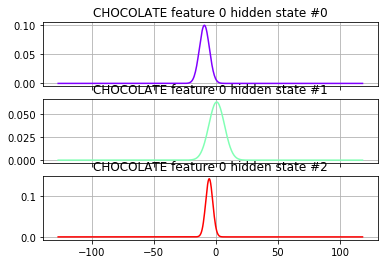

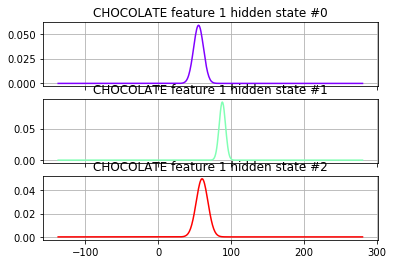

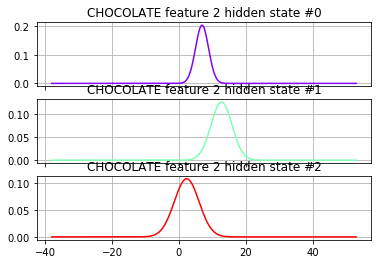

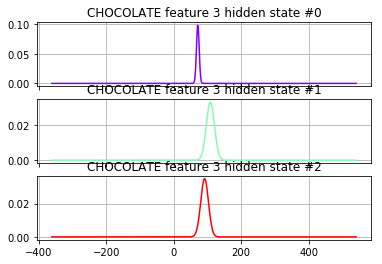

In [21]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx])*3)
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx])*3)
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 500)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])

            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))
            ax.grid(True)
        
        figures.append(plt)

    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [22]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [23]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [24]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [25]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [36]:
# DONE: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14, verbose=False).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.5883889569959138 seconds
Training complete for BOOK with 6 states with time 4.683364987999084 seconds
Training complete for VEGETABLE with 2 states with time 2.0086668680014554 seconds
Training complete for FUTURE with 2 states with time 4.374132519995328 seconds
Training complete for JOHN with 12 states with time 45.45154933498998 seconds


In [31]:
# DONE: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.44567654200363904 seconds
Training complete for BOOK with 5 states with time 2.28257545499946 seconds
Training complete for VEGETABLE with 3 states with time 0.9197114949929528 seconds
Training complete for FUTURE with 4 states with time 2.4527393390017096 seconds
Training complete for JOHN with 10 states with time 22.167897206003545 seconds


In [28]:
# DONE: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 1.0023154519949458 seconds
Training complete for BOOK with 15 states with time 4.571624463998887 seconds
Training complete for VEGETABLE with 15 states with time 3.629568221993395 seconds
Training complete for FUTURE with 15 states with time 4.618103453001822 seconds
Training complete for JOHN with 15 states with time 24.876429415999155 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

Cross validation is the most widely used model for hyperparameters tuning in machine learning. The cross validation procedure has the advantage to be an estimator of the out of sample test error at hence optimizing during cross validation allows optimizing the hyperparameters for a lower for test error. However, cross validation is known to be a time consuming procedure as it requires multiple rounds of splitting and refitting the data.

Bayesian Information Criterion implements the priciple of the Occam razor and penalizes models with high flexibility (number of free parameters). As we can see from the above evaluation it produces the models with the least number of hidden states, it is fast to evaluate and relatively easy to implement.

Discriminative Information Criterion tries to find the number of parameters which makes the model for a particular word as specific as possible. The objective function for this criterion maximize the log likelyhood for a particular of the word on which the model was learned while at the same time minimizing the average log likelyhood of the other words under that model. It is quite fast to compute as there are not multiple training rounds as cross validation, but tends to produce models with higher number of states.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [37]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 55.997s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [38]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [39]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [40]:
# DONE implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [49]:
# DONE Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)

In [42]:
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6685393258426966
Total correct: 59 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO                               JOHN IX THINK MARY LOVE
   43: *FRANK *GO BUY HOUSE         

In [ ]:
# DONE Choose a feature set and model selector
# DONE Recognize the test set and display the result with the show_errors method
models = train_all_words(features_custom, SelectorCV)
test_set = asl.build_test(features_custom)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


In [ ]:
# DONE Choose a feature set and model selector
# DONE Recognize the test set and display the result with the show_errors method

models = train_all_words(features_custom, SelectorBIC)
test_set = asl.build_test(features_custom)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)



**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

To find the best model selector and feature combination in term of WER I run and exaustive saarch benchmark as implemented in `optimize_method.py`, the result of this script are stored in `model_evaluation.csv`. As we can see from this result the best best and second combination in terms of WER are `(features_custom, SelectorCV)` and `(features_custom, SelectorBIC )` both with a WER of 50% .

These results were summarized in the following plot:

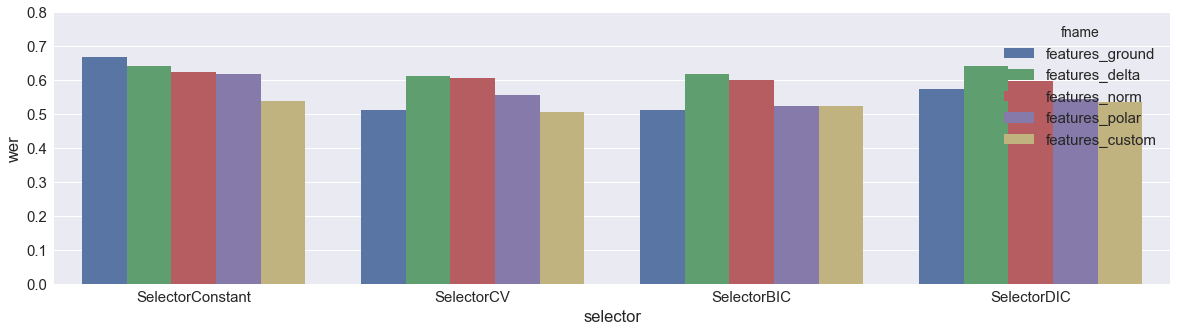

In [85]:
me = pd.read_csv('model_evaluation.csv')
plt.figure(figsize=(20,5))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
sns.barplot(x='selector',y='wer',hue='fname',data=me)
plt.ylim((0,.8));
plt.savefig('plots/wer.png')

As we can see both cross validation and BIC perform similarly while DIC (even if still better than the constant selector) is slightly worse than the other two when less powerful features are involved.

The average WER for the selectors is summarized in the table below, where we can see that while both CV and BIC peform similarly BIC is much faster to evaluate

In [89]:
me.groupby('selector').mean()

,time,wer
selector,,
SelectorBIC,174.149724,0.555056
SelectorCV,297.640967,0.558427
SelectorConstant,51.508338,0.617978
SelectorDIC,329.869005,0.577528


In terms of features, we can see that the custom features which were designed really improve performance compared to ground 
features thanks to more robust handling of the variability among speaker and the other reasosn outlined above

In [90]:
me.groupby('fname').mean()

,time,wer
fname,,
features_custom,195.324783,0.525281
features_delta,202.252765,0.627809
features_ground,190.366052,0.566011
features_norm,199.675842,0.606742
features_polar,278.840601,0.560393


Overall it is not possible to achieve WER below 50%. As suggested in the lecture, to improve the error we could leverage the intuition that certain bigrams and trigrams of words are more lucky to happen than others, such intuition could be embedded in a [statistical language model (SLM)](https://en.wikipedia.org/wiki/Language_model) and implemented by learning the HMM on tuples (or triplets) of words.

Also categorizing the word by type (such as noums, adjectives, and  verbs) and incorporating this knowledge in the transition matrix could help achieving higher accuracy.

Finally modeling the correlation among features and multimodal features by using `GaussianMixtureModelHHMM` may improve performance, while still we would have to be careful not to overfit.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [50]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 87.638s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!